## **Library**: 
Load the libraries needed for the project.
Main libraries used are:
- **Machine learning**: `sklearn`, `shap`, `xgboost`
- **Data manipulation**: `numpy`, `pandas`
- **Plot**: `seaborn`, `matplotlib`
- **Python tools**: `pickle`


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
import shap
from sklearn.ensemble import (RandomForestClassifier, HistGradientBoostingClassifier)
from sklearn.base import clone
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, train_test_split)
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm, tree, datasets
from xgboost import XGBClassifier
from sklearn.metrics import (r2_score, f1_score, precision_score, 
                             recall_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score)


## **Functions**:

- **run_on_splits**: 
  A decorator function that iterates over different data splits (train, validation, test) and applies the decorated function to each split.

- **evaluate/evaluate2**:
  These functions evaluate the performance of a model on a given dataset. The `evaluate` function calculates precision and confusion matrix, while `evaluate2` provides a more detailed evaluation by also calculating recall, F1 score, and accuracy. Both functions append the evaluation results to a global list for later analysis.

- **save_model**:
  This function saves a trained model to a specified file path using the pickle library. It ensures that trained models can be saved and loaded for future use or analysis without needing to retrain them.

- **fit_and_evaluate**:
  This function performs hyperparameter tuning using RandomizedSearchCV, fits the model to the training data, saves the trained model, and then evaluates the model on different splits of the data. It can be parameterized to use different scoring metrics and save paths, providing flexibility in model evaluation.

- **fit_dummy_classifier**:
  This function fits a dummy classifier, which serves as a baseline model, to the training data. It then evaluates the performance of the dummy classifier to provide a comparison point for more sophisticated models.

- **fit_and_evaluate_models**:
  This function orchestrates the fitting and evaluation of multiple models (e.g., SVM, Decision Tree, Random Forest, XGBoost, HistGradientBoosting). It uses the `fit_and_evaluate` function to handle hyperparameter tuning, training, saving, and evaluation for each model, ensuring a comprehensive analysis of different machine learning algorithms on the dataset.

In [4]:

def run_on_splits(func):
    def _run_loop(*args, **kwargs):
        for x,y,nsplit in zip([X_train, X_val, X_test],
                              [y_train, y_val, y_test],
                              ['train', 'val', 'test']):
            func(*args, X=x, y=y, nsplit=nsplit, **kwargs)
    return _run_loop

@run_on_splits
def evaluate(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    predict_y = model.predict(X)
    precision = precision_score(y, predict_y, average='weighted')
    conf_matrix = confusion_matrix(y, predict_y)

    performances.append({'model': model_name,
                         'split': nsplit,
                         'precision': precision,
                         'confusion_matrix': conf_matrix.tolist()})


@run_on_splits
def evaluate_2(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    predict_y = model.predict(X)
    precision = precision_score(y, predict_y, average='weighted')
    recall = recall_score(y, predict_y, average='weighted')
    f1 = f1_score(y, predict_y, average='weighted')
    accuracy = accuracy_score(y, predict_y)

    performances.append({
        'model': model_name,
        'split': nsplit,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    })

# Example usage:
# evaluate_2(some_model, X_test, y_test, 'test_split', 'model_name')



def save_model(reg, model_name, subset_name):
    with open(f'/Users/sylvainestebe/Code/data_child/models/Q1_{model_name}_{subset_name}.pkl', 'wb') as file:
        pkl.dump(reg, file)

def fit_and_evaluate(model, param_grid, model_name, X_train, y_train, subset_name):
    search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='precision', cv=5, n_jobs=-1, n_iter=50)
    reg = search.fit(X_train, y_train)
    save_model(reg, model_name, subset_name)
    evaluate(model=search.best_estimator_, model_name=f'{model_name}_{subset_name}')

def fit_dummy_classifier(X_train, y_train, subset_name):
    dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
    dummy_clf.fit(X_train, y_train)
    evaluate(model=dummy_clf, model_name=f'dummy_{subset_name}')

def fit_and_evaluate_models(X_train, y_train, subset_name):
    fit_dummy_classifier(X_train, y_train, subset_name)

    # SVM
    fit_and_evaluate(
        svm.SVC(probability=True),
    {'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']}, 
        'svm',
        X_train, y_train, subset_name
    )

    # Decision Tree
    fit_and_evaluate(
        tree.DecisionTreeClassifier(random_state=42), 
            {'max_depth': [2, 5], 
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']}
    , 
        'tree',
        X_train, y_train, subset_name
    )

    # Random Forest
    fit_and_evaluate(
        RandomForestClassifier(random_state=42), 
            {'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}, 
        'randomforest',
        X_train, y_train, subset_name
    )

    # XGBoost
    fit_and_evaluate(
        XGBClassifier(random_state=42), 
       {'n_estimators': [10, 100],
 'max_depth': [3, 6],
 'learning_rate': [0.01, 0.1],
 'min_child_weight': [1, 3],
 'subsample': [0.8, 1.0]},  
        'xgboost',
        X_train, y_train, subset_name
    )

    # HistGradientBoosting
    fit_and_evaluate(
        HistGradientBoostingClassifier(random_state=42),
        {'learning_rate': [0.01, 0.1],
 'max_iter': [100, 200],
 'max_depth': [3, 6]},  
        'histgradientboosting',
        X_train, y_train, subset_name
    )

def save_model_2(reg, model_name, subset_name):
    with open(f'/Users/sylvainestebe/Code/data_child/models/Q2_{model_name}_{subset_name}.pkl', 'wb') as file:
        pkl.dump(reg, file)

def fit_and_evaluate_2(model, param_grid, model_name, X_train, y_train, subset_name):
    search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, n_iter=50)
    reg = search.fit(X_train, y_train)
    save_model_2(reg, model_name, subset_name)
    evaluate_2(model=search.best_estimator_, model_name=f'{model_name}_{subset_name}')

def fit_dummy_classifier(X_train, y_train, subset_name):
    dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
    dummy_clf.fit(X_train, y_train)
    evaluate_2(model=dummy_clf, model_name=f'dummy_{subset_name}')

def fit_and_evaluate_models_2(X_train, y_train, subset_name):
    fit_dummy_classifier(X_train, y_train, subset_name)

    # SVM
    fit_and_evaluate_2(
        svm.SVC(probability=True),
    {'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']}, 
        'svm',
        X_train, y_train, subset_name
    )

    # Decision Tree
    fit_and_evaluate_2(
        tree.DecisionTreeClassifier(random_state=42), 
            {'max_depth': [2, 5], 
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']}
    , 
        'tree',
        X_train, y_train, subset_name
    )

    # Random Forest
    fit_and_evaluate_2(
        RandomForestClassifier(random_state=42), 
            {'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}, 
        'randomforest',
        X_train, y_train, subset_name
    )

    # XGBoost
    fit_and_evaluate_2(
        XGBClassifier(random_state=42), 
       {'n_estimators': [10, 100],
 'max_depth': [3, 6],
 'learning_rate': [0.01, 0.1],
 'min_child_weight': [1, 3],
 'subsample': [0.8, 1.0]},  
        'xgboost',
        X_train, y_train, subset_name
    )

    # HistGradientBoosting
    fit_and_evaluate_2(
        HistGradientBoostingClassifier(random_state=42),
        {'learning_rate': [0.01, 0.1],
 'max_iter': [100, 200],
 'max_depth': [3, 6]},  
        'histgradientboosting',
        X_train, y_train, subset_name
    )

# **Data**
Loading,Explore and feature selection/engeenering of the dataset

In [33]:
# Loading dataset
data_child = pd.read_csv("../data/dataset.csv",low_memory=False)

In [34]:
# Create a subset of the dataset with variables of interest
data = {
    # Demographic data
    'Age': data_child.Age,
    'Region': data_child.Dep,  # Encode region data as a categorical feature
    'Postcode': data_child.CodePostalBaseline,  # Encode postcode data as a categorical feature
    'SingleMom': data_child.SingleMum,
    'Couple': data_child.Couple,
    'Relationship_type': data_child.Relationship,
    'Educ': data_child.Educ,
    'Income': data_child.IncomeBaseline,
    'Job': data_child.Occupation,
    'Job_partner': data_child.Occupation2,
    'Job_After': data_child.AfterBirthOccupation,

    # Knowledge data
    'NumberKnown': data_child.KnownNbTypeECS,
    'Computer_access': data_child.ComputerYN,

    # Trust data
    'Trust_creche': data_child.TrustCreche1or0,

    # Easy to access data
    'Access': data_child.AccessEasyBaseline,

    # Psy data
    'Happy': data_child.PsyWellBeingHappy,
    'Quite': data_child.PsyWellBeingQuite,
    'Vigou': data_child.PsyWellBeingVigou,
    'Fresh': data_child.PsyWellBeingFresh,
    'Stimu': data_child.PsyWellBeingStimu,

    # Values data
    'ValGenerosity': data_child.ValGenerosity,
    'ValIndependence': data_child.ValIndependence,
    'ValSocialisation': data_child.ValSocialisation,
    'ValObedience': data_child.ValObedience,
    'ValEducation': data_child.ValEducation,
    'ValDK': data_child.ValDK,
    'ValImagination': data_child.ValImagination,

    # Economic difficulties
    'DeprivFood': data_child.DeprivFood,
    'DeprivBills': data_child.DeprivBills,
    'DeprivHolidays': data_child.DeprivHolidays,
    'DeprivHousing': data_child.DeprivHousing,

    # Norms data
    'TradNorm': data_child.TradNormsScore,

    # Output
    'Intention': data_child.Intention,  # Intention to put a baby in a structure
    'Applied': data_child.ECSApp,  # Applied for a structure
    'Use': data_child.ECSUseYes  # Use a structure (hence accepted)
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

# Set pandas options to display all columns
pd.set_option('display.max_columns', None)

# Check the first few rows of the DataFrame to ensure it converted correctly
df.head(10)

,Age,Region,Postcode,SingleMom,Couple,Relationship_type,Educ,Income,Job,Job_partner,Job_After,NumberKnown,Computer_access,Trust_creche,Access,Happy,Quite,Vigou,Fresh,Stimu,ValGenerosity,ValIndependence,ValSocialisation,ValObedience,ValEducation,ValDK,ValImagination,DeprivFood,DeprivBills,DeprivHolidays,DeprivHousing,TradNorm,Intention,Applied,Use
0,30,94,94600,False,True,Couple cohabitant,Sup,1000-1500,"Je travaille (y compris si congé maladie, mate...","est au chômage, cherche un emploi",Oui,2,Oui,1,très difficile,Plus de la moitié du temps,Tout le temps,La plupart du temps,La plupart du temps,Tout le temps,1,0,0,0,0,0,1,Pas du tout,Pas du tout,Pas du tout,Pas du tout,0,Yes,1,1
1,36,94,94800,False,True,Couple cohabitant,Bac,1000-1500,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",Oui,2,Oui,1,assez difficile,La plupart du temps,La plupart du temps,Plus de la moitié du temps,Plus de la moitié du temps,La plupart du temps,0,1,1,0,0,0,0,Pas du tout,Pas du tout,Un peu,Pas du tout,0,Yes,1,0
2,29,93,93600,False,True,Couple cohabitant,Sup,2500-3000,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",Oui,2,Oui,1,assez difficile,Plus de la moitié du temps,Plus de la moitié du temps,Moins de la moitié du temps,La plupart du temps,Plus de la moitié du temps,0,1,0,0,0,0,1,Pas du tout,Pas du tout,Pas du tout,Pas du tout,0,Yes,1,1
3,43,75,75019,False,True,Couple non cohabitant,Sup,2500-3000,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",Oui,1,Oui,1,très difficile,La plupart du temps,Plus de la moitié du temps,La plupart du temps,Plus de la moitié du temps,Tout le temps,0,0,1,0,0,0,1,Pas du tout,Pas du tout,Pas du tout,Pas du tout,0,Yes,1,1
4,40,94,94430,False,True,Couple cohabitant,Sup,3000-4500,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",Oui,1,Oui,1,assez facile,Plus de la moitié du temps,Plus de la moitié du temps,Juste de temps en temps,Juste de temps en temps,Plus de la moitié du temps,0,1,0,0,1,0,0,Pas du tout,Pas du tout,Pas du tout,Pas du tout,0,Yes,1,1
5,44,94,94320,False,True,Couple cohabitant,Sup,- 500,"Je suis étudiant(e), stagiaire ou fait une for...","travaille (y compris si congé maladie, materni...",Oui,1,Oui,1,assez difficile,La plupart du temps,Juste de temps en temps,Plus de la moitié du temps,La plupart du temps,Moins de la moitié du temps,0,1,1,0,0,0,0,Pas du tout,Pas du tout,Un peu,Pas du tout,0,Yes,0,0
6,33,94,94450,False,True,Couple cohabitant,Sup,- 500,Je suis femme au foyer,"travaille (y compris si congé maladie, materni...",Oui,1,Oui,1,assez difficile,Moins de la moitié du temps,La plupart du temps,Juste de temps en temps,Juste de temps en temps,Moins de la moitié du temps,0,1,0,0,0,0,1,Pas du tout,Pas du tout,Un peu,Pas du tout,0,Yes,0,0
7,47,93,93200,False,True,Couple cohabitant,Bac,NaN,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",Oui,2,Oui,1,assez difficile,Plus de la moitié du temps,La plupart du temps,La plupart du temps,La plupart du temps,La plupart du temps,0,1,0,0,1,0,0,Pas du tout,Pas du tout,Un peu,Pas du tout,0,Yes,1,1
8,34,75,75012,False,True,Couple cohabitant,Bac,- 500,Je suis femme au foyer,"travaille (y compris si congé maladie, materni...",Oui,2,Oui,1,très difficile,Plus de la moitié du temps,Moins de la moitié du temps,Moins de la moitié du temps,Juste de temps en temps,Juste de temps en temps,0,1,0,0,1,0,0,Pas du tout,Pas du tout,Un peu,Pas du tout,0,No,0,0
9,31,94,94410,False,True,Couple cohabitant,Sup,1500-2000,"Je travaille (y compris si congé maladie, mate...","travaille (y compris si congé maladie, materni...",Oui,3,Oui,1,très difficile,La plupart du temps,Juste de temps en temps,Juste de temps en temps,Jamais,Juste de temps en temps,0,0,1,0,1,0,0,Pas du tout,Pas du tout,Un peu,Pas du tout,50,Yes,1,1


## **Preprocessing**:

- **Checking and Handling Missing Values**: Identify and fill missing values with mean for numerical columns.
- **Consistency**: Ensure consistent data, particularly for categorical variables.
- **Encoding Categorical Data**: Encode categorical variables using `LabelEncoder`.
- **Combining Classes**: Create a new column `Combined` that merges information from `Applied` and `Use`.
- **Creating Aggregated Columns**: Generate aggregated columns like `Total_Deprivation`, `Total_Values`, and `Total_Psy`.
- **Scaling Numerical Columns**: Standardize `Age` and `Income` using `StandardScaler`.

In [35]:
# Check for missing values
print(df.isnull().sum())
# Replace na values with mean
df.Income = df.Income.fillna(str(df.Income.mean))
df.DeprivBills = df.DeprivBills.fillna(str(df.DeprivBills.mean))
df.DeprivHolidays = df.DeprivHolidays.fillna(str(df.DeprivBills.mean))
df.DeprivFood = df.DeprivFood.fillna(str(df.DeprivBills.mean))

Age                   0
Region                0
Postcode              0
SingleMom             0
Couple                0
Relationship_type     0
Educ                  0
Income               97
Job                   0
Job_partner           0
Job_After             0
NumberKnown           0
Computer_access       0
Trust_creche          0
Access                0
Happy                 0
Quite                 0
Vigou                 0
Fresh                 0
Stimu                 0
ValGenerosity         0
ValIndependence       0
ValSocialisation      0
ValObedience          0
ValEducation          0
ValDK                 0
ValImagination        0
DeprivFood            1
DeprivBills          15
DeprivHolidays       19
DeprivHousing         8
TradNorm              0
Intention             0
Applied               0
Use                   0
dtype: int64


In [36]:
# check in their are inconsistency in the dataset 
df.dtypes
# there are some objects data (string) and booleen data. I would like to convert everything in number.

Age                   int64
Region                int64
Postcode              int64
SingleMom              bool
Couple                 bool
Relationship_type    object
Educ                 object
Income               object
Job                  object
Job_partner          object
Job_After            object
NumberKnown           int64
Computer_access      object
Trust_creche          int64
Access               object
Happy                object
Quite                object
Vigou                object
Fresh                object
Stimu                object
ValGenerosity         int64
ValIndependence       int64
ValSocialisation      int64
ValObedience          int64
ValEducation          int64
ValDK                 int64
ValImagination        int64
DeprivFood           object
DeprivBills          object
DeprivHolidays       object
DeprivHousing        object
TradNorm              int64
Intention            object
Applied               int64
Use                   int64
dtype: object

In [37]:
# List of categorical columns
categorical_columns = ['Job', 'Job_partner', 'Job_After', 'Computer_access',
                       'DeprivFood', 'DeprivBills', 'DeprivHolidays', 'DeprivHousing',
                       'Postcode', 'Region', 'Educ', 'Couple', 'Relationship_type',
                       'Access', 'Happy', 'Quite', 'Vigou', 'Fresh', 'Stimu', 'Intention', 'SingleMom', 'Income']

# Dictionary to store LabelEncoders
label_encoders = {}

# Initialize and apply LabelEncoder for each categorical column
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Function to print the encoding of a specific column
def print_encoding(column):
    le = label_encoders[column]
    print(f"\n{column} encoding:")
    for index, class_ in enumerate(le.classes_):
        print(f"{index}: {class_}")

# Print the encoding for all categorical columns
for column in categorical_columns:
    print_encoding(column)





Job encoding:
0: Autre
1: Je suis au chômage, cherche un emploi
2: Je suis femme au foyer
3: Je suis étudiant(e), stagiaire ou fait une formation
4: Je travaille (y compris si congé maladie, maternité ou parental)

Job_partner encoding:
0: Autre
1: No Partner
2: est au chômage, cherche un emploi
3: est femme / homme au foyer
4: est étudiant(e), stagiaire ou fait une formation
5: travaille (y compris si congé maladie, maternité ou parental)

Job_After encoding:
0: Ne sait pas
1: Non
2: Oui

Computer_access encoding:
0: Non
1: Oui

DeprivFood encoding:
0: <bound method NDFrame._add_numeric_operations.<locals>.mean of 0                                             Pas du tout
1                                             Pas du tout
2                                             Pas du tout
3                                             Pas du tout
4                                             Pas du tout
5                                             Pas du tout
6                           

In [38]:
# Combine classes into one column
def combine_classes(row):
    if row['Applied'] == 0 and row['Use'] == 0:
        return 0
    elif row['Applied'] == 1 and row['Use'] == 0:
        return 1
    elif row['Applied'] == 1 and row['Use'] == 1:
        return 2

df['Combined'] = df.apply(combine_classes, axis=1)

# Create aggregated columns
df['Total_Deprivation'] = df[['DeprivFood', 'DeprivBills', 'DeprivHolidays', 'DeprivHousing']].sum(axis=1)
df['Total_Values'] = df[['ValGenerosity', 'ValIndependence', 'ValSocialisation', 'ValObedience', 'ValEducation', 'ValDK', 'ValImagination']].sum(axis=1)
df['Total_Psy'] = df[['Happy', 'Quite', 'Vigou', 'Fresh', 'Stimu']].sum(axis=1)

# Scale Age and Income
scaler = StandardScaler()
df[['Age', 'Income']] = scaler.fit_transform(df[['Age', 'Income']])

# Check the first few rows of the DataFrame to ensure it loaded correctly
df.head(50)

,Age,Region,Postcode,SingleMom,Couple,Relationship_type,Educ,Income,Job,Job_partner,Job_After,NumberKnown,Computer_access,Trust_creche,Access,Happy,Quite,Vigou,Fresh,Stimu,ValGenerosity,ValIndependence,ValSocialisation,ValObedience,ValEducation,ValDK,ValImagination,DeprivFood,DeprivBills,DeprivHolidays,DeprivHousing,TradNorm,Intention,Applied,Use,Combined,Total_Deprivation,Total_Values,Total_Psy
0,-0.419513,2,99,0,1,0,1,-0.714911,4,2,2,2,1,1,5,4,5,2,2,5,1,0,0,0,0,0,1,3,3,3,2,0,1,1,1,2,11,2,18
1,0.647294,2,101,0,1,0,0,-0.714911,4,5,2,2,1,1,0,2,2,4,4,2,0,1,1,0,0,0,0,3,3,4,2,0,1,1,0,1,12,2,14
2,-0.597314,1,55,0,1,0,1,0.336500,4,5,2,2,1,1,0,4,4,3,2,4,0,1,0,0,0,0,1,3,3,3,2,0,1,1,1,2,11,2,17
3,1.891902,0,18,0,1,1,1,0.336500,4,5,2,1,1,1,5,2,4,2,4,5,0,0,1,0,0,0,1,3,3,3,2,0,1,1,1,2,11,2,17
4,1.358499,2,88,0,1,0,1,0.686970,4,5,2,1,1,1,1,4,4,1,1,4,0,1,0,0,1,0,0,3,3,3,2,0,1,1,1,2,11,2,14
5,2.069703,2,79,0,1,0,1,-1.065382,3,5,2,1,1,1,0,2,1,4,2,3,0,1,1,0,0,0,0,3,3,4,2,0,1,0,0,0,12,2,12
6,0.113890,2,90,0,1,0,1,-1.065382,2,5,2,1,1,1,0,3,2,1,1,3,0,1,0,0,0,0,1,3,3,4,2,0,1,0,0,0,12,2,10
7,2.603107,1,31,0,1,0,0,2.088852,4,5,2,2,1,1,0,4,2,2,2,2,0,1,0,0,1,0,0,3,3,4,2,0,1,1,1,2,12,2,12
8,0.291692,0,11,0,1,0,0,-1.065382,2,5,2,2,1,1,5,4,3,3,1,1,0,1,0,0,1,0,0,3,3,4,2,0,0,0,0,0,12,2,12
9,-0.241712,2,86,0,1,0,1,-0.364441,4,5,2,3,1,1,5,2,1,1,0,1,0,0,1,0,1,0,0,3,3,4,2,50,1,1,1,2,12,2,5


## **Exploratory**: 

- **Visualizing the Intention and Combined Output**:
  - Create subplots to visualize the frequency of `Intention` and `Combined` outputs.

- **Visualizing the Distribution of Numerical Features**:
  - Create histograms for all numerical columns to understand their distribution.

- **Visualizing Box Plots to Check for Outliers**:
  - Use box plots to visualize the distribution and identify potential outliers in numerical features.

- **Visualizing the Correlation Matrix**:
  - Visualize the correlation matrix to identify the relationships between features.

- **Analyzing Correlations with Target Variables**:
  - Identify features with strong positive and negative correlations with the target variables `Intention` and `Combined`.

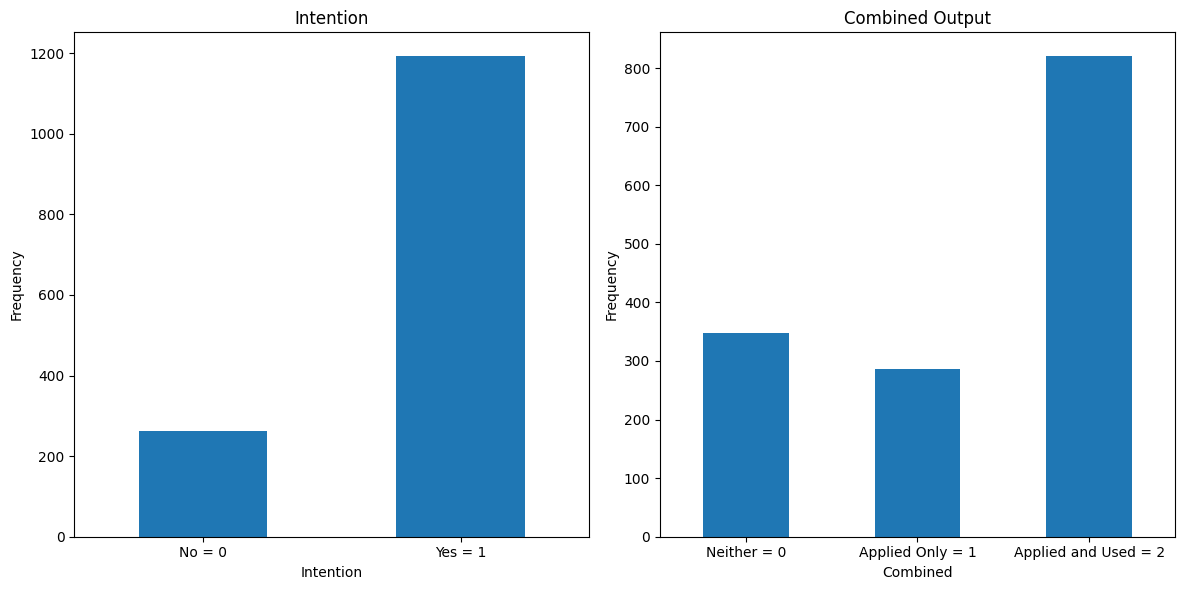

In [12]:
# Visualize the Intention and Combined output using subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Intention plot
intention_counts = df["Intention"].value_counts().sort_index(ascending=True)
intention_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Intention')
axes[0].set_xlabel('Intention')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No = 0', 'Yes = 1'], rotation=0)

# Combined plot
combined_counts = df["Combined"].value_counts().sort_index()
combined_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Combined Output')
axes[1].set_xlabel('Combined')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['Neither = 0', 'Applied Only = 1', 'Applied and Used = 2'], rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
# Visualize the distribution of numerical features
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

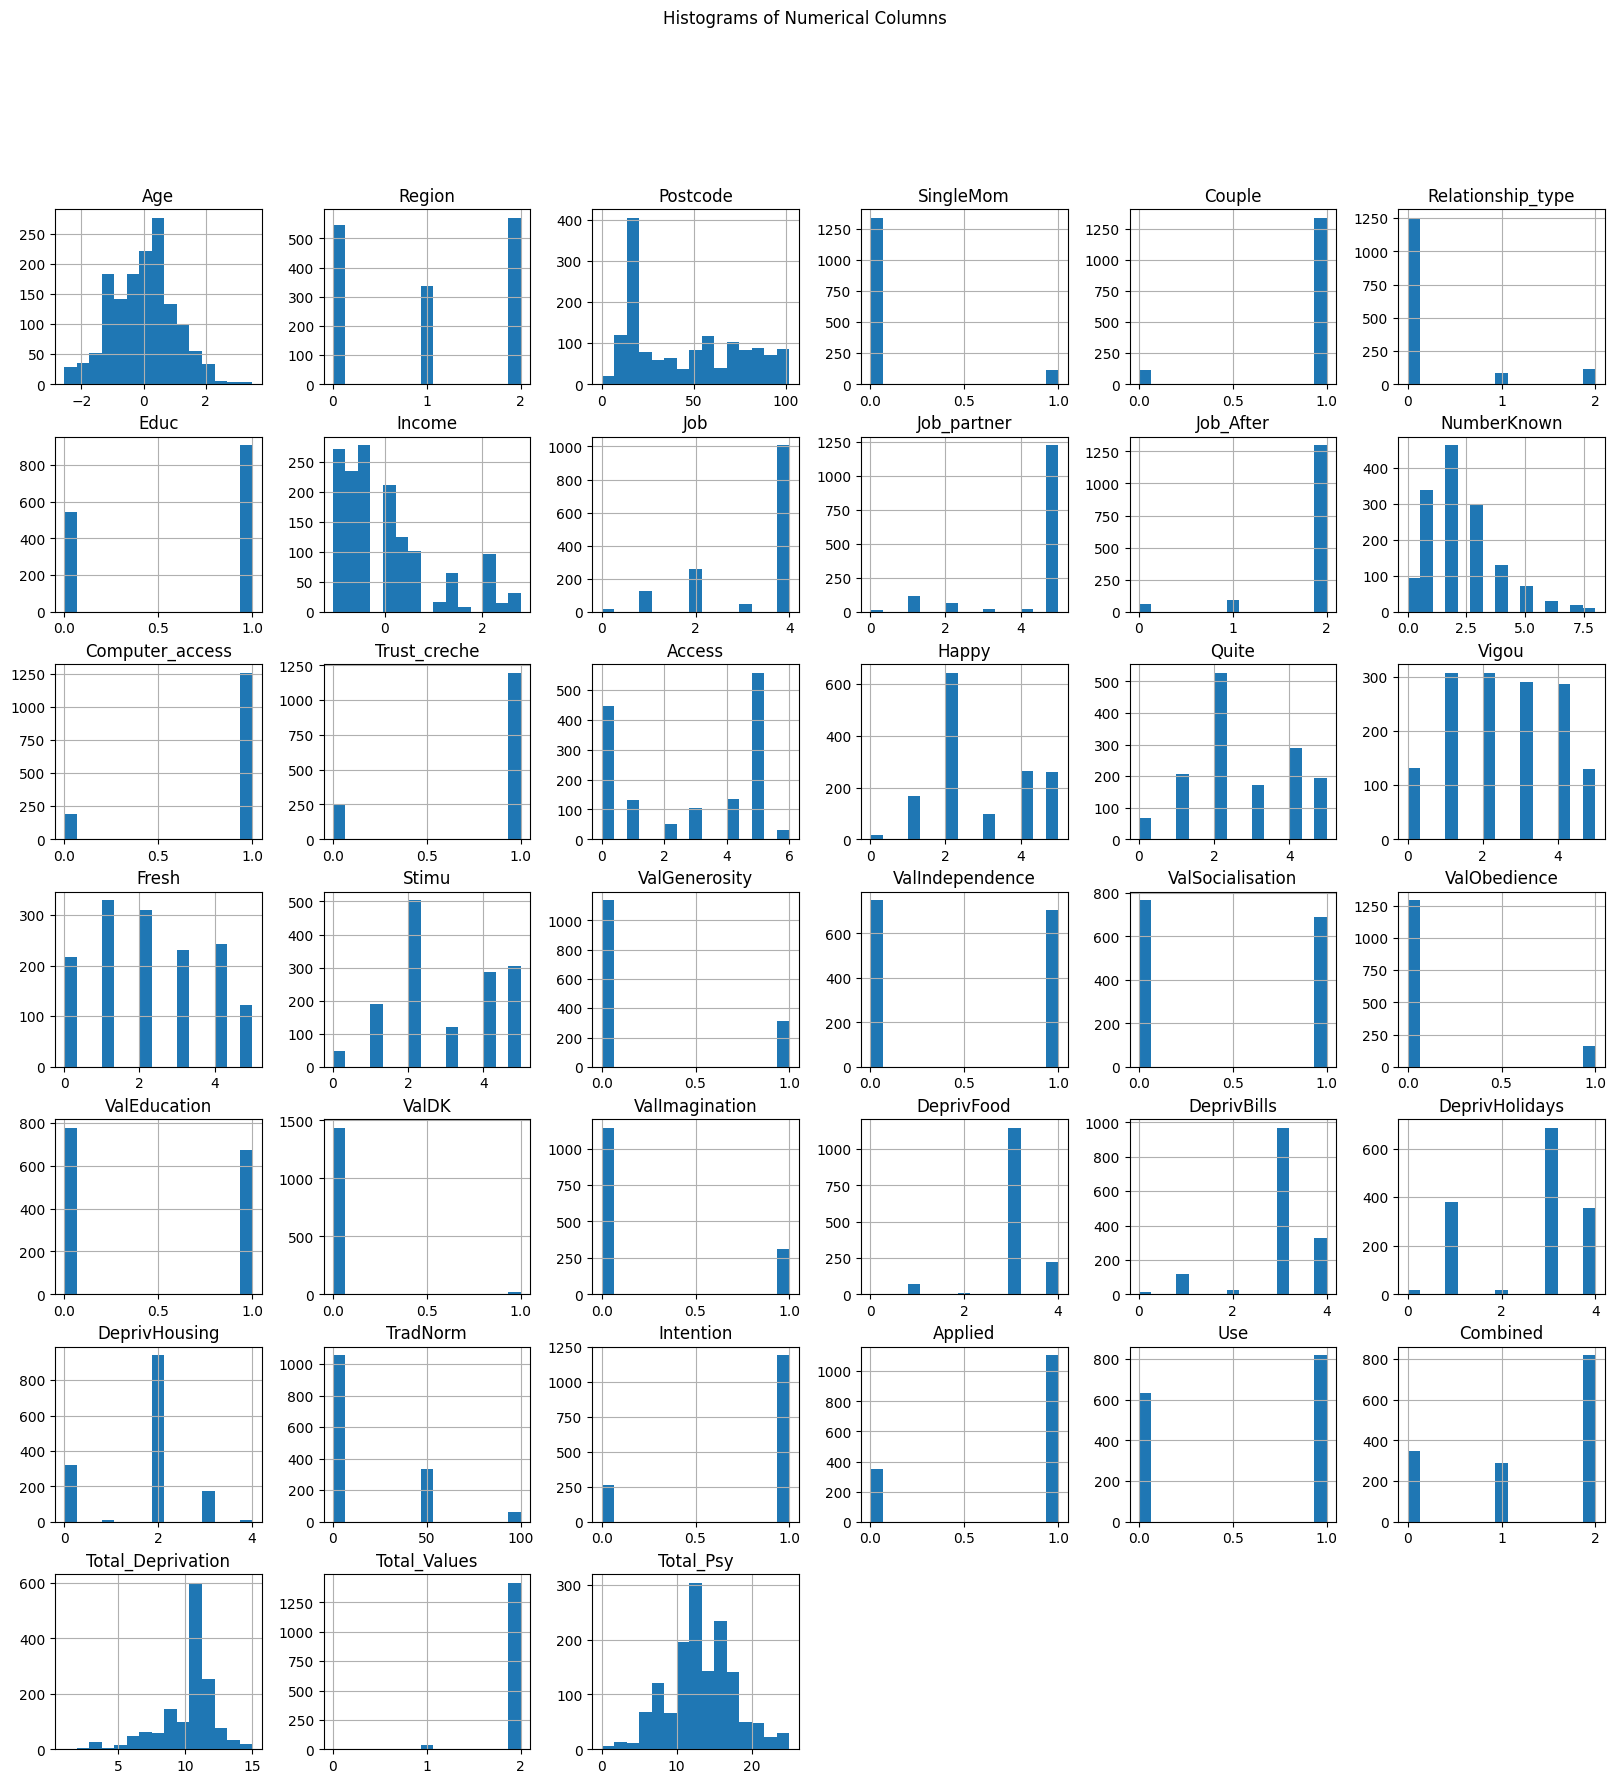

In [14]:
# Visualize the distribution of numerical features
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms for numerical columns
df[numerical_columns].hist(figsize=(20, 20), bins=15)
plt.suptitle('Histograms of Numerical Columns')
plt.show()

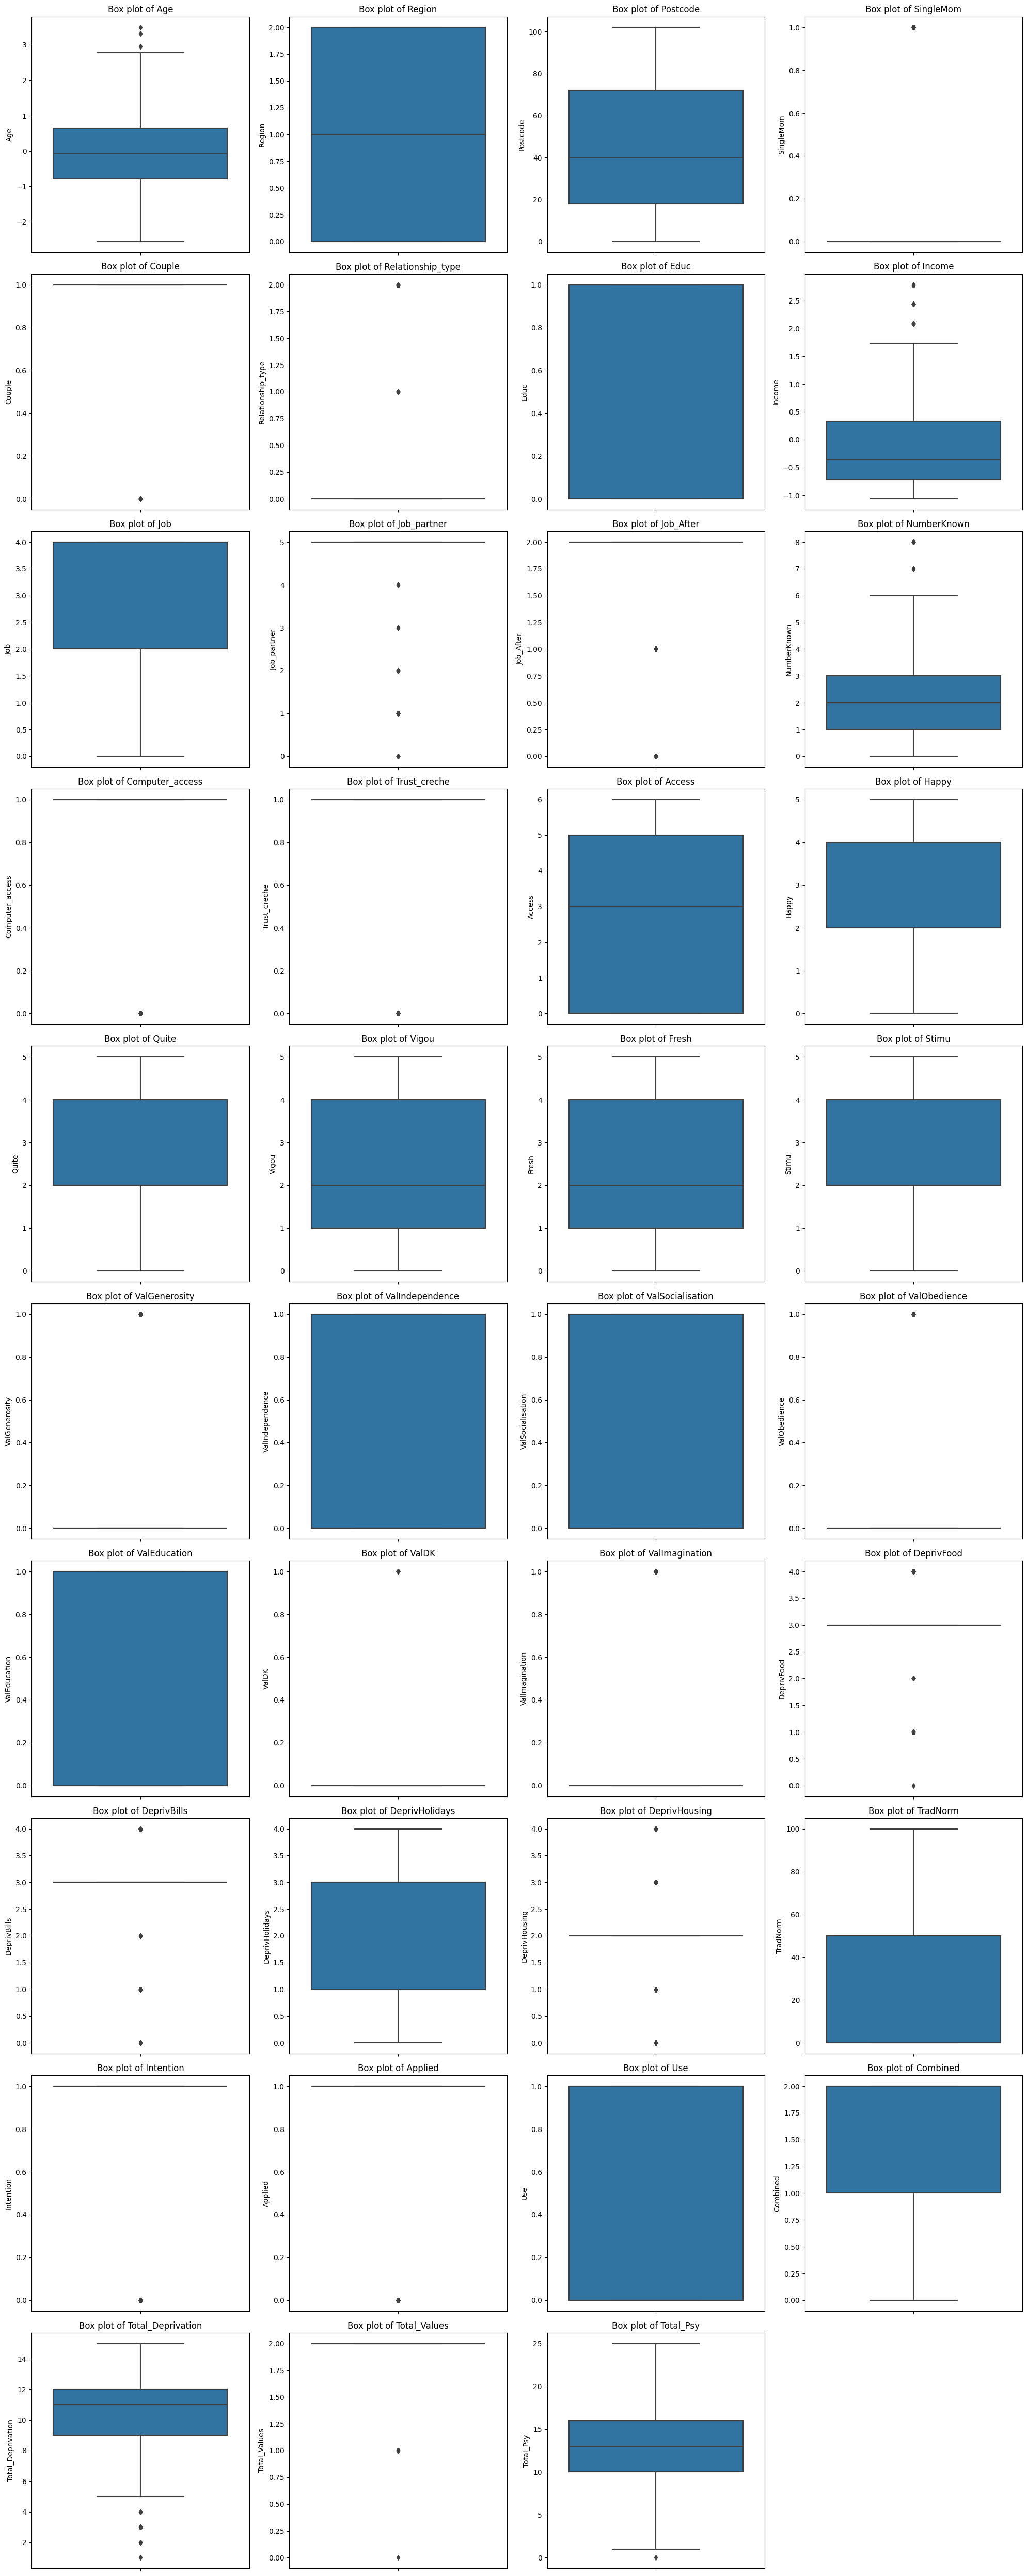

In [15]:
num_cols = len(numerical_columns)
num_rows = (num_cols + 3) // 4  # This will create enough rows to accommodate all columns

# Visualize box plots to check for outliers
plt.figure(figsize=(20, num_rows * 5))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.boxplot(data=df, y=column)
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

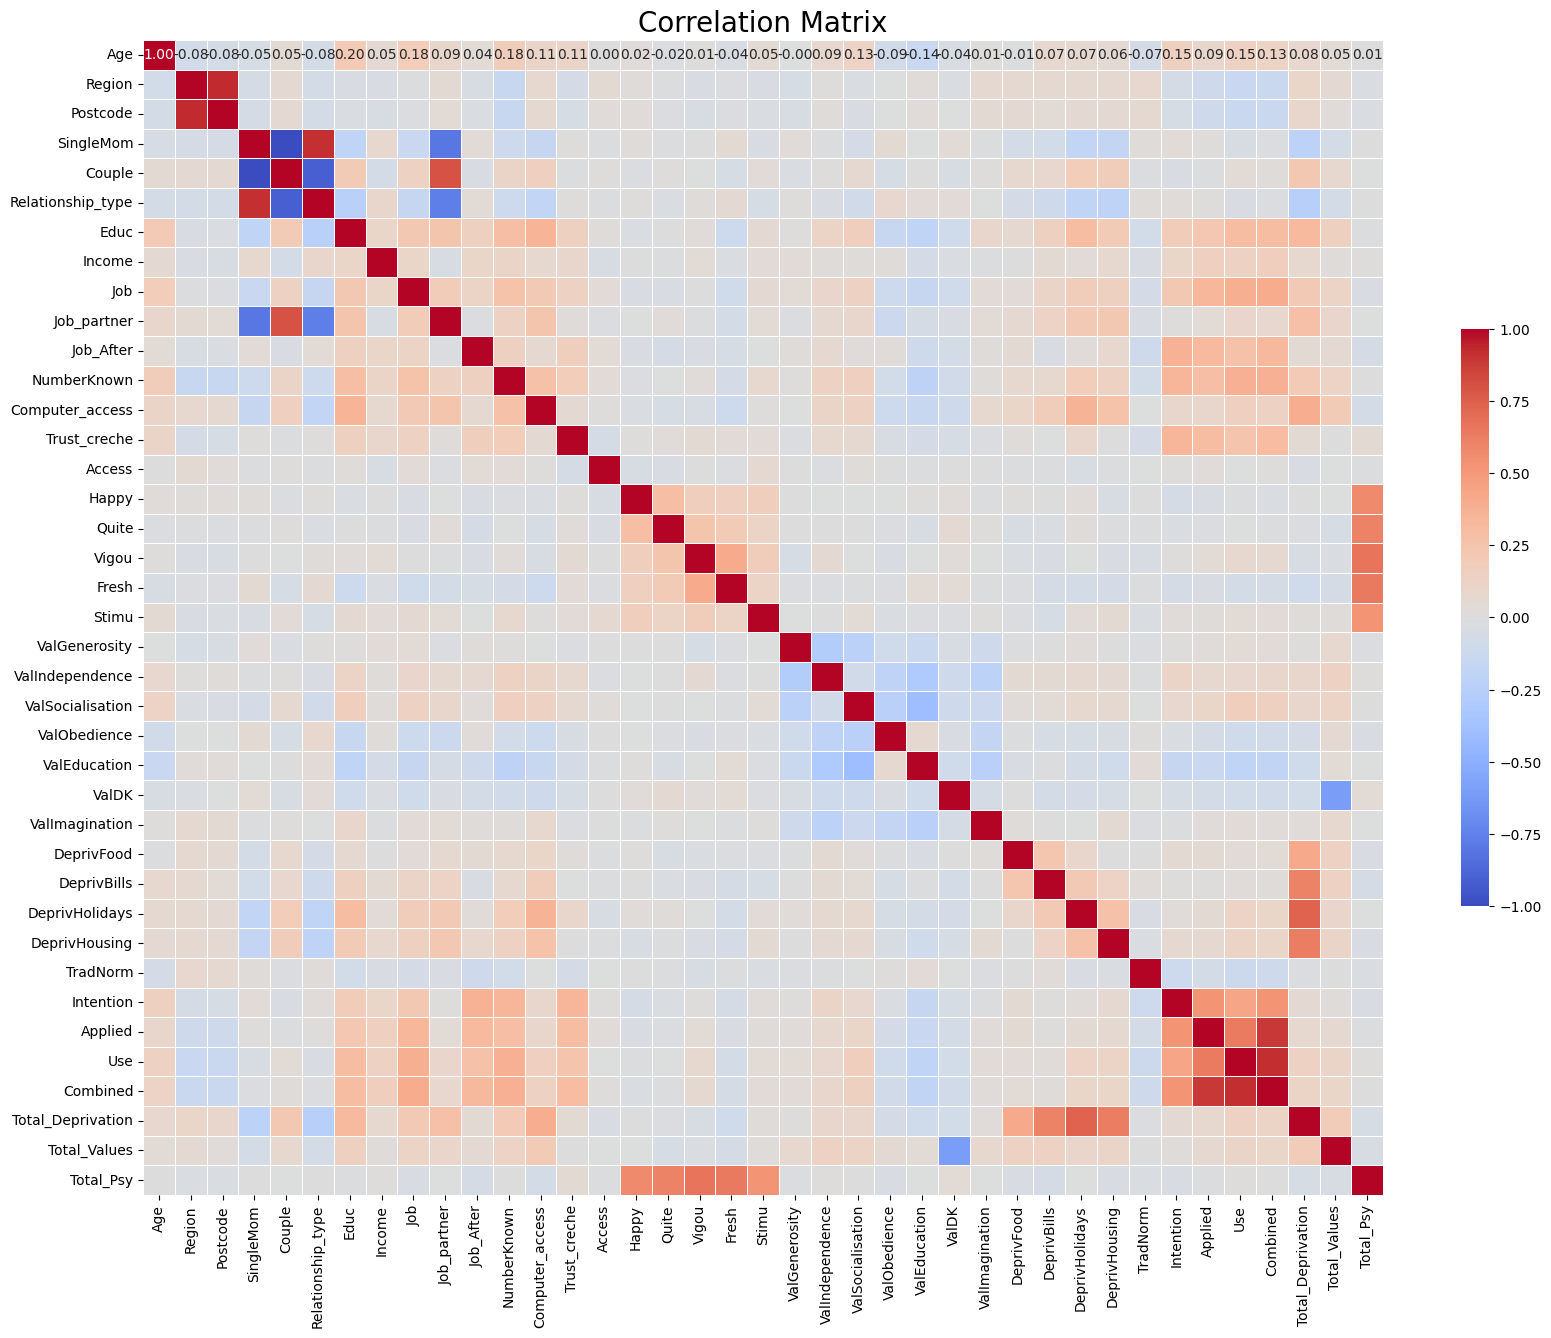

In [16]:
# Visualize correlation matrix
plt.figure(figsize=(20, 15))  # Adjusted size for better visibility
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix', size=20)
plt.show()


Select value above 0.15 or -0.15 

In [17]:
# Set thresholds positive and negative correlations
positive_threshold = 0.15
negative_threshold = -0.15

# Find features with positive and negative correlation with the target variable
target_correlations = correlation_matrix['Intention']
strong_positive_correlations = target_correlations[target_correlations > positive_threshold]
strong_negative_correlations = target_correlations[target_correlations < negative_threshold]

print("Strong Positive Correlations:\n", strong_positive_correlations)
print("Strong Negative Correlations:\n", strong_negative_correlations)

Strong Positive Correlations:
 Age             0.150056
Educ            0.189255
Job             0.225074
Job_After       0.369547
NumberKnown     0.349656
Trust_creche    0.344437
Intention       1.000000
Applied         0.523757
Use             0.443746
Combined        0.531023
Name: Intention, dtype: float64
Strong Negative Correlations:
 ValEducation   -0.160461
Name: Intention, dtype: float64


Feature selection for Use and Applied

In [18]:
# Find features with positive and negative correlation with the target variable
target_correlations = correlation_matrix['Combined']
strong_positive_correlations = target_correlations[target_correlations > positive_threshold]
strong_negative_correlations = target_correlations[target_correlations < negative_threshold]

print("Strong Positive Correlations:\n", strong_positive_correlations)
print("Strong Negative Correlations:\n", strong_negative_correlations)


Strong Positive Correlations:
 Educ                0.297636
Income              0.167620
Job                 0.404149
Job_After           0.322676
NumberKnown         0.375596
Trust_creche        0.307219
ValSocialisation    0.154631
Intention           0.531023
Applied             0.889115
Use                 0.919251
Combined            1.000000
Name: Combined, dtype: float64
Strong Negative Correlations:
 ValEducation   -0.190233
Name: Combined, dtype: float64


## **Model Preparation and Data Splitting**:

- **Preparing Datasets for Performance Comparison**:
  - **Data Preparation for Question 1**: Select relevant features and remove specified columns.
  - **Data Preparation for Question 2**: Filter and select relevant features, then remove specified columns.

- **Splitting Data into Training, Validation, and Test Sets**:
  - Split the datasets into training, validation, and test sets for both questions.
  - Save the splits into separate CSV files for later use.

### **Detailed Steps**:

- **Prepare Datasets for Question 1**:
  - Select relevant features: `['Age', 'Educ', 'Job', 'Job_After', 'NumberKnown', 'Trust_creche', 'ValEducation', 'Intention']`.
  - Remove columns: `['Intention', 'Applied', 'Use', 'Combined']`.
  - Create `X` (predictors) and `y` (intention) variables.
  - Split into training, validation, and test datasets.
  - Save the splits into CSV files: `train.csv`, `val.csv`, `test.csv`.

- **Prepare Datasets for Question 2**:
  - Filter to remove rows where `Intention` is 0.
  - Select relevant features: `['Educ', 'Job', 'Job_After', 'NumberKnown', 'Computer_access', 'Trust_creche', 'ValSocialisation', 'Combined']`.
  - Remove columns: `['Intention', 'Applied', 'Use', 'Combined']`.
  - Create `X` (predictors) and `y` (combined) variables.
  - Split into training, validation, and test datasets.
  - Save the splits into CSV files: `train_features.csv`, `val_features.csv`, `test_features.csv`.



In [19]:
# Prepare performance dataset to compare differents model before choose the best
data_question_1 = df.copy()
df_select_q1 = data_question_1[['Age', 'Educ', 'Job', 'Job_After', 'NumberKnown', 'Trust_creche', 'ValEducation', 'Intention']]
# Liste des colonnes à enlever
colonnes_a_enlever = ['Intention', 'Applied', 'Use','Combined']
# Enlever les colonnes spécifiées
data_question_1_X = data_question_1.drop(columns=colonnes_a_enlever)
data_question_1_X["Intention"] =  data_question_1.iloc[:,32]

data_question_2_to_filter = df.copy()
data_question_2 = data_question_2_to_filter.drop(data_question_2_to_filter[data_question_2_to_filter.Intention == 0].index)
# Selecting the specified columns for df_select_q2
df_select_q2 = data_question_2[['Educ', 'Job', 'Job_After', 'NumberKnown', 'Computer_access', 'Trust_creche', 'ValSocialisation', 'Combined']]
# Liste des colonnes à enlever
colonnes_a_enlever = ['Intention', 'Applied', 'Use','Combined']
# Enlever les colonnes spécifiées
data_question_2_X = data_question_2.drop(columns=colonnes_a_enlever)
data_question_2_X["Combined"] =  data_question_2.iloc[:,35]

In [20]:
# Create the X (differents predictor) and Y (intention) variables 
X = data_question_1_X.iloc[:,:35].values
y = data_question_1_X.iloc[:,35].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = data_question_1_X.columns
    df.to_csv(f'../data/{name}.csv')
print("Datasets saved successfully.")


Datasets saved successfully.


In [21]:
# Create the X (differents predictor) and Y (intention) variables 
X = df_select_q1.iloc[:,:7].values
y = df_select_q1.iloc[:,7].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = df_select_q1.iloc[:,:8].columns
    df.to_csv(f'../data/{name}_features.csv')
print("Datasets saved successfully.")

Datasets saved successfully.


In [22]:
# Create the X (differents predictor) and Y (combined question 2) variables 
X = data_question_2_X.iloc[:,:35].values
y = data_question_2_X.iloc[:,35].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df_2 = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df_2.columns = data_question_2_X.columns
    df_2.to_csv(f'../data/{name}_question2.csv')
print("Datasets saved successfully.")

Datasets saved successfully.


In [23]:
# Create the X (differents predictor) and Y (combined question 2) variables 
X = df_select_q2.iloc[:,:7].values
y = df_select_q2.iloc[:,7].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

columns = [f'feature_{i}' for i in range(7)] + ['Combined']

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = df_select_q2.iloc[:,:8].columns
    df.to_csv(f'../data/{name}_question2_features.csv')
print("Datasets saved successfully.")

Datasets saved successfully.


## **Model Training and Evaluation for question one**:

- **Loading and Preparing Datasets**:
  - Load training, validation, and test datasets for model training.
  - Load datasets with selected features for focused analysis.

- **Splitting Data into Features and Labels**:
  - Split the datasets into `X` (predictors) and `y` (target variables).

- **Model Fitting and Evaluation**:
  - Fit and evaluate models using different subsets of data: demographic data, selected features, and all data.
  - Save and compare model performances.

- **Hyperparameter Tuning**:
  - Perform hyperparameter tuning using `GridSearchCV` on the best model.
  - Save and evaluate the best model.

- **Visualizing Model Performance**:
  - Create scatter plots to compare precision scores of different models.
  - Plot and save confusion matrices for the best models.
  - Visualize feature importance using SHAP values.

In [24]:
# Load dataset 
train = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train.csv', index_col=0)
val = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val.csv', index_col=0)
test = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test.csv', index_col=0)
performances = []

# Load dataset features selections
train_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train_features.csv', index_col=0)
val_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val_features.csv', index_col=0)
test_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test_features.csv', index_col=0)
performances = []

In [25]:
# Demographic data
X_train, y_train = train.iloc[:, :-26], train.iloc[:, -1]
X_val, y_val = val.iloc[:, :-26], val.iloc[:, -1]
X_test, y_test = test.iloc[:, :-26], test.iloc[:, -1]

fit_and_evaluate_models(X_train, y_train, subset_name="demographic")

# Feature selection
X_train, y_train = train_features.iloc[:, :-1], train_features.iloc[:, -1]
X_val, y_val = val_features.iloc[:, :-1], val_features.iloc[:, -1]
X_test, y_test = test_features.iloc[:, :-1], test_features.iloc[:, -1]

fit_and_evaluate_models(X_train, y_train, subset_name="feature_select")

# All data
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_val, y_val = val.iloc[:, :-1], val.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

fit_and_evaluate_models(X_train, y_train, subset_name="all")

/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/

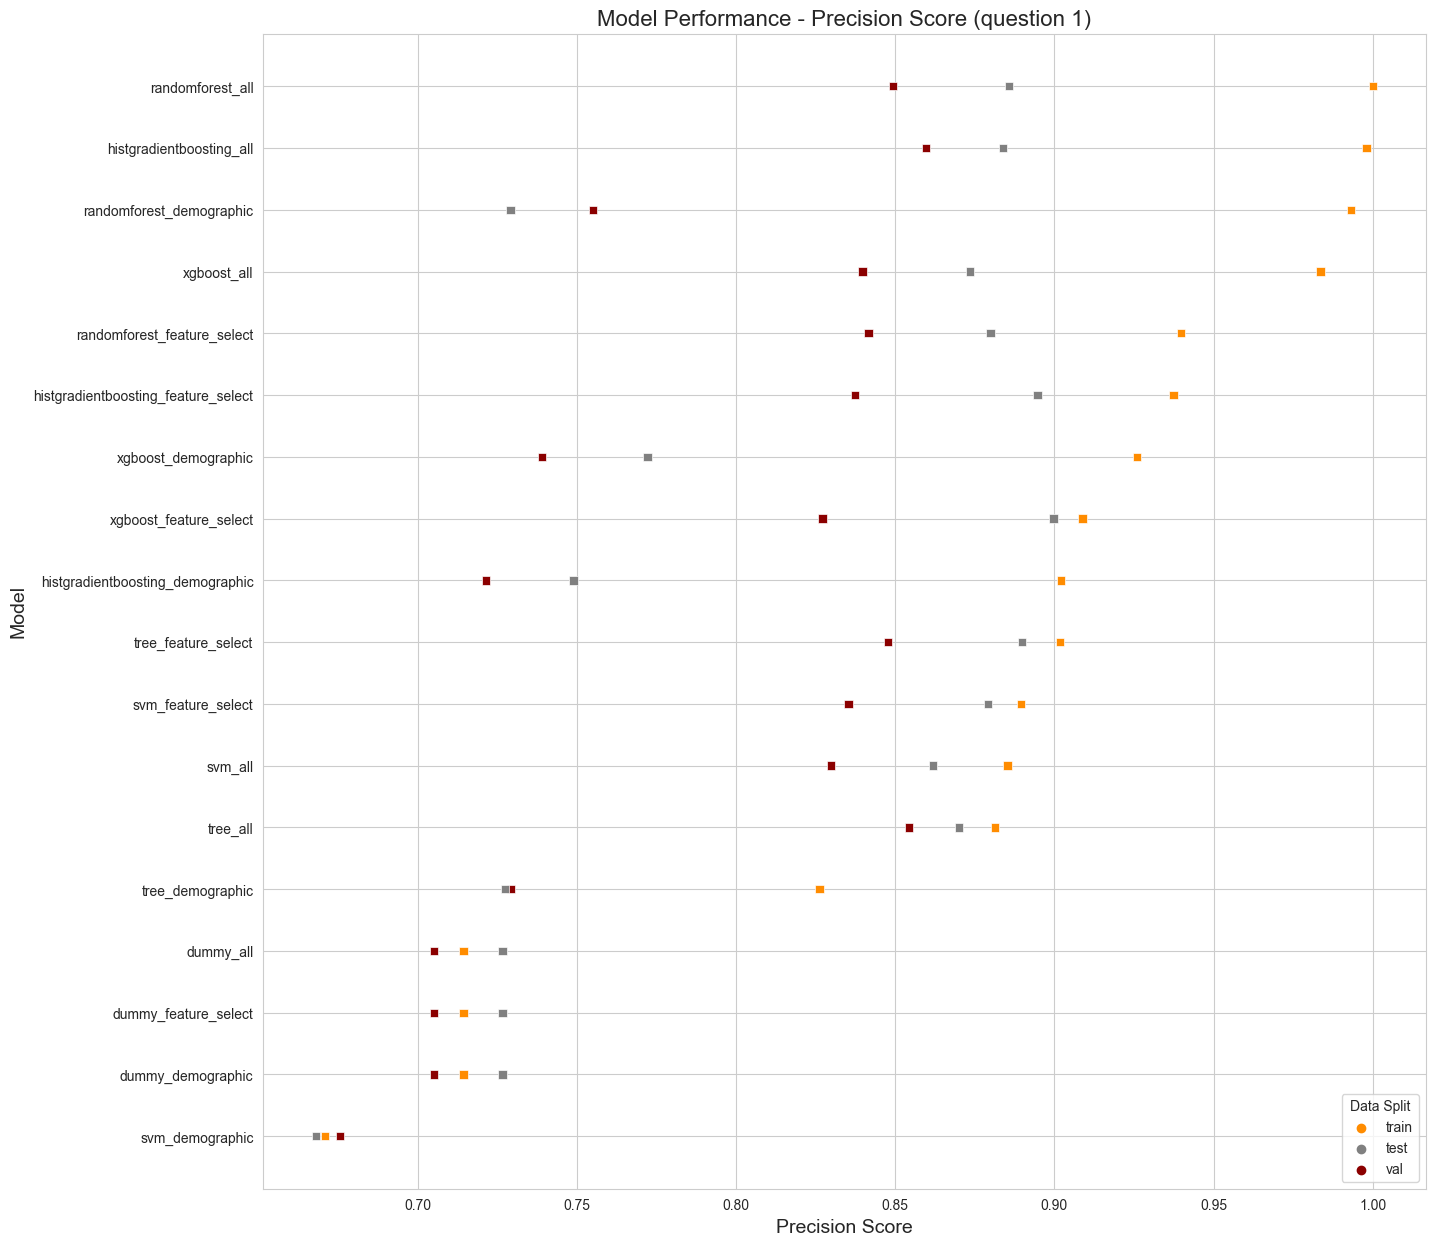

In [26]:
perf_df = pd.DataFrame(performances)
# Set seaborn style
sns.set_style('whitegrid')
# Create a figure for the plot
plt.figure(figsize=(15, 15))
# Create the scatter plot
sns.scatterplot(data=perf_df.sort_values(by='precision', ascending=False), 
                        y='model', 
                        x='precision', 
                        marker='s', 
                        hue='split', 
                        palette=['darkorange', 'grey', 'darkred'])

# Add plot title and labels
plt.title("Model Performance - Precision Score (question 1)", fontsize=16)
plt.xlabel("Precision Score", fontsize=14)
plt.ylabel("Model", fontsize=14)
# Customize legend
plt.legend(title='Data Split', loc='lower right')
# Show the plot
plt.show()


In [27]:
# funcrion which tune the model selected
def fit_and_evaluate_best(X_train, y_train, subset_name):
    xgb_model = XGBClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 10, 100]
    }
    search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='precision', cv=5, n_jobs=-1)
    search.fit(X_train, y_train)
    save_model(search, 'xgboost', subset_name)
    evaluate(model=search.best_estimator_, model_name=f'xgboost_{subset_name}')

In [28]:
# Feature selection
X_train, y_train = train_features.iloc[:, :-1], train_features.iloc[:, -1]
X_val, y_val = val_features.iloc[:, :-1], val_features.iloc[:, -1]
X_test, y_test = test_features.iloc[:, :-1], test_features.iloc[:, -1]

fit_and_evaluate_best(X_train, y_train, subset_name="best_feature_")

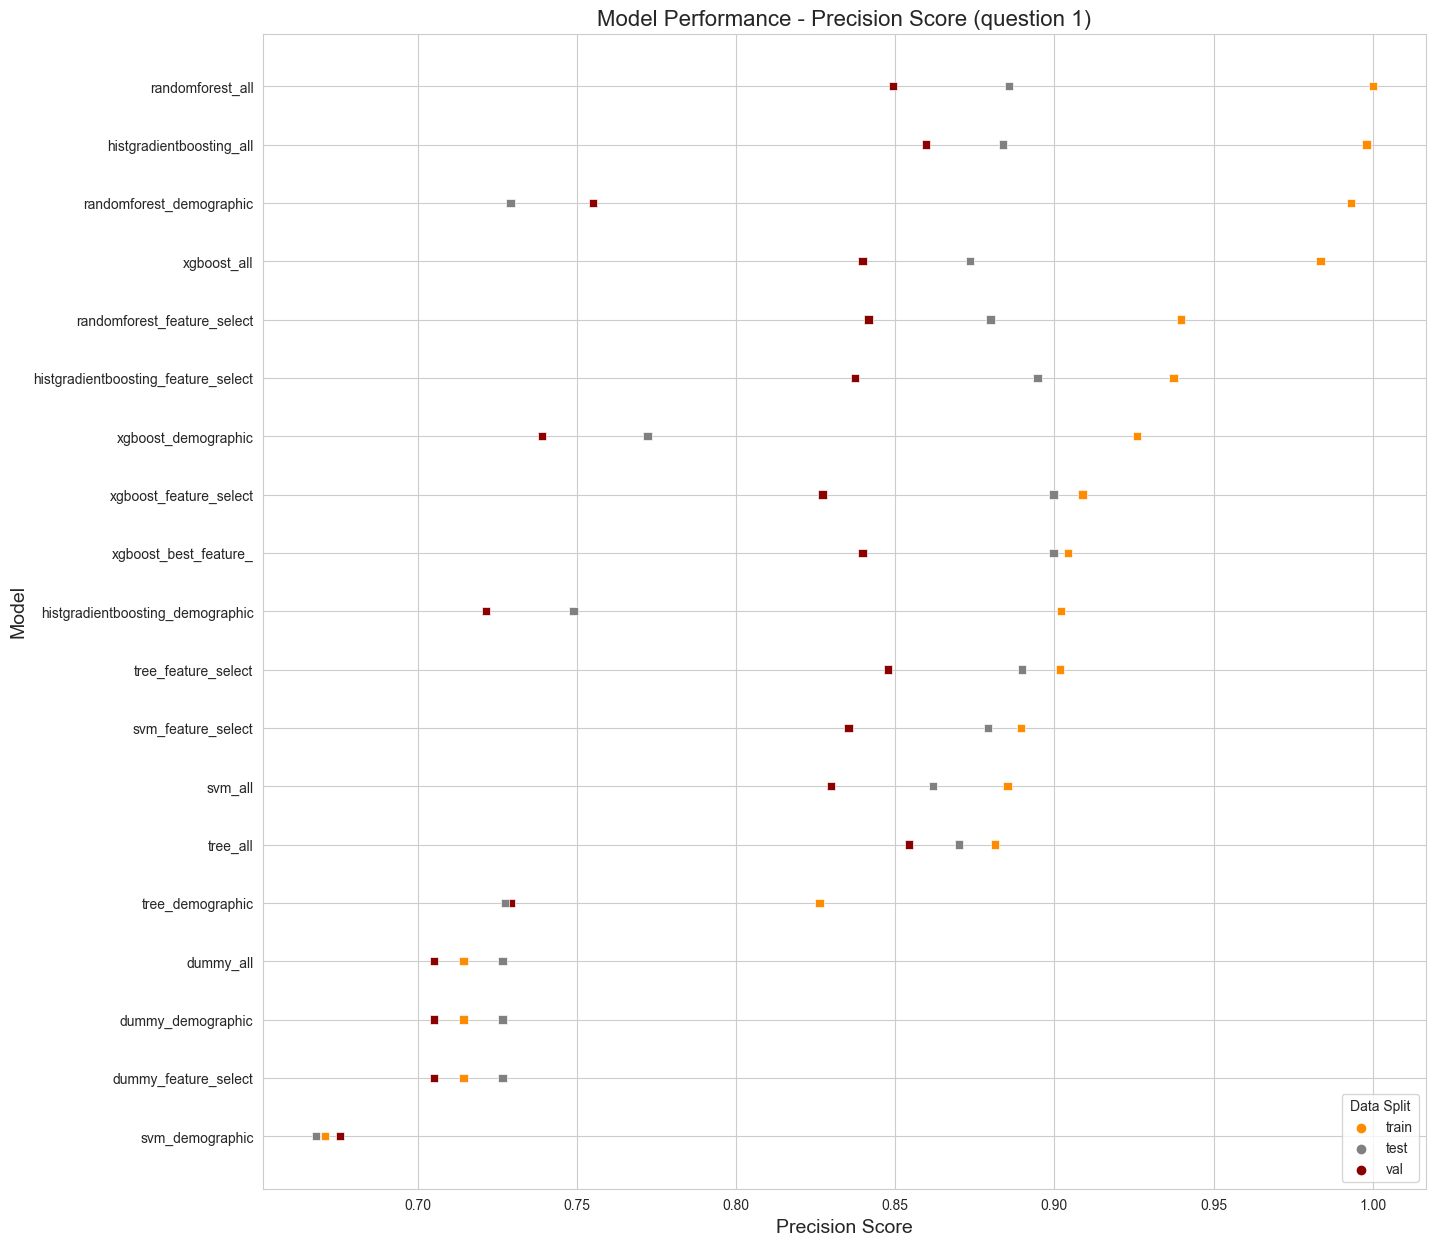

In [29]:
perf_df = pd.DataFrame(performances)
# Set seaborn style
sns.set_style('whitegrid')
# Create a figure for the plot
plt.figure(figsize=(15, 15))
# Create the scatter plot
sns.scatterplot(data=perf_df.sort_values(by='precision', ascending=False), 
                        y='model', 
                        x='precision', 
                        marker='s', 
                        hue='split', 
                        palette=['darkorange', 'grey', 'darkred'])

# Add plot title and labels
plt.title("Model Performance - Precision Score (question 1)", fontsize=16)
plt.xlabel("Precision Score", fontsize=14)
plt.ylabel("Model", fontsize=14)
# Customize legend
plt.legend(title='Data Split', loc='lower right')
# save the plot
plt.savefig('/Users/sylvainestebe/Code/data_child/fig/Q1_best_model.png', dpi=300)

# Show the plot
plt.show()


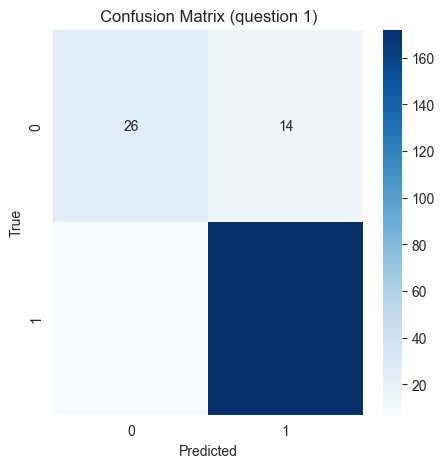

In [30]:
# Load the best model
best_model = pkl.load(open('/Users/sylvainestebe/Code/data_child/models/Q1_xgboost_best_feature_.pkl', 'rb'))

# Predict on the validation set
best_preds = best_model.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, best_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True,  cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix (question 1)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/Users/sylvainestebe/Code/data_child/fig/Q1_confusion_matrice', dpi=300)

plt.show()



In [31]:
print(classification_report(y_test, best_preds))

              precision    recall  f1-score   support

         0.0       0.79      0.65      0.71        40
         1.0       0.92      0.96      0.94       179

    accuracy                           0.90       219
   macro avg       0.86      0.81      0.83       219
weighted avg       0.90      0.90      0.90       219



In [ ]:
best_model.best_estimator_

In [ ]:
# Feature importance
# Create an explainer object
explainer = shap.Explainer(best_model.best_estimator_, X_train)
shap_values = explainer(X_train)

# Create the SHAP summary plot and save it
plt.figure(figsize=(8, 6))  # Adjusting size for better readability
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar', show=False)

# Adding the new title and simplified x-axis label
plt.title("Average Feature Importance on Model Prediction (SHAP Values)")
plt.xlabel("Mean SHAP Value (Average Impact on Model)")

plt.tight_layout()
plt.savefig("/Users/sylvainestebe/Code/data_child/fig/Q1_features_importance.png", dpi=700)
plt.show()


The SHAP summary plot
The values are in terms of log odds of a positive prediction.
Each dot represents the impact of a specific feature value on the model's prediction for a single instance. 

In [ ]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_model.best_estimator_, X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot without showing it
plt.figure(figsize=(8, 6))  # Adjusting size for better readability
shap.summary_plot(shap_values, X_test, show=False)

# Adding the new title
plt.title("SHAP Summary Plot for Predicting Intention to Apply for a Structure")

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("/Users/sylvainestebe/Code/data_child/fig/Q1_features_sum.png", dpi=700)
plt.show()

## **Model Training and Evaluation (Question 2)**:

- **Loading and Preparing Datasets**:
  - Load training, validation, and test datasets for model training.
  - Load datasets with selected features for focused analysis.

- **Splitting Data into Features and Labels**:
  - Split the datasets into `X` (predictors) and `y` (target variables).

- **Model Fitting and Evaluation**:
  - Fit and evaluate models using different subsets of data: demographic data, selected features, and all data.
  - Save and compare model performances.

- **Hyperparameter Tuning**:
  - Perform hyperparameter tuning using `GridSearchCV` on the best model.
  - Save and evaluate the best model.

- **Visualizing Model Performance**:
  - Create scatter plots to compare F1 scores of different models.
  - Plot and save confusion matrices for the best models.
  - Visualize feature importance using SHAP values.


In [ ]:
# Load dataset 
train = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train_question2.csv', index_col=0)
val = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val_question2.csv', index_col=0)
test = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test_question2.csv', index_col=0)
performances = []


# Load dataset features selections
train_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train_question2_features.csv', index_col=0)
val_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val_question2_features.csv', index_col=0)
test_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test_question2_features.csv', index_col=0)
performances = []

In [ ]:
## DEMOGRAPHIC
X_train, y_train = train.iloc[:,:-26], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-26], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-26], test.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="demographic")
## Features selections
X_train, y_train = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_val, y_val = val_features.iloc[:,:-1], val_features.iloc[:,-1]
X_test, y_test = test_features.iloc[:,:-1], test_features.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="features selections")

## All data
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-1], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="all")


### Performance

In [ ]:
perf_df = pd.DataFrame(performances)
# Set seaborn style
sns.set_style('whitegrid')
# Create a figure for the plot
plt.figure(figsize=(15, 15))
# Create the scatter plot
sns.scatterplot(data=perf_df.sort_values(by='precision', ascending=False), 
                        y='model', 
                        x='f1', 
                        marker='s', 
                        hue='split', 
                        palette=['darkorange', 'grey', 'darkred'])

# Add plot title and labels
plt.title("Model Performance - Precision Score (question 2)", fontsize=16)
plt.xlabel("Precision Score", fontsize=14)
plt.ylabel("Model", fontsize=14)
# Customize legend
plt.legend(title='Data Split', loc='lower right')
# Show the plot
plt.show()


In [ ]:
# Tune the model selected
def fit_and_evaluate_best_2(X_train, y_train, subset_name):
    xgb_model = XGBClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 10, 100]
    }
    search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
    search.fit(X_train, y_train)
    save_model_2(search, 'xgboost', subset_name)
    evaluate_2(model=search.best_estimator_, model_name=f'xgboost_{subset_name}')

In [ ]:
## All data
X_train, y_train = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_val, y_val = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_test, y_test = train_features.iloc[:,:-1], train_features.iloc[:,-1]

fit_and_evaluate_best_2(X_train, y_train, subset_name="best_feature_")


In [ ]:
perf_df = pd.DataFrame(performances)
# Set seaborn style
sns.set_style('whitegrid')
# Create a figure for the plot
plt.figure(figsize=(10, 10))
# Create the scatter plot
sns.scatterplot(data=perf_df.sort_values(by='f1', ascending=False), 
                        y='model', 
                        x='f1', 
                        marker='s', 
                        hue='split', 
                        palette=['darkorange', 'grey', 'darkred'])

# Add plot title and labels
plt.title("Model Performance - F1 Score (Question 2)", fontsize=16)
plt.xlabel("Weighted F1 score", fontsize=14)
plt.ylabel("Model", fontsize=14)
# Automatically adjust x-axis limits based on data
# Customize legend
plt.legend(title='Data Split', loc='lower right')
#  save the plot to a file
plt.savefig('/Users/sylvainestebe/Code/data_child/fig/Q2_model_performance_f1.png', dpi=300)
# Show the plot
plt.show()


In [ ]:
## All data
X_train, y_train = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_val, y_val = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_test, y_test = train_features.iloc[:,:-1], train_features.iloc[:,-1]

# Load the best model
best_model = pkl.load(open('/Users/sylvainestebe/Code/data_child/models/Q2_xgboost_best_feature_.pkl', 'rb'))


In [ ]:
best_model.best_estimator_

In [ ]:
# Predict on the validation set
best_preds = best_model.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, best_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Question 2)')
plt.savefig('/Users/sylvainestebe/Code/data_child/fig/Q2_confusion.png', dpi=300)

plt.show()


In [ ]:
# Print classification report
print(classification_report(y_test, best_preds))
best_model

The bar chart  illustrates the average SHAP values for various features across three different classes (0, 1, and 2)

Check how is code computer access and valsocialisaton

In [ ]:
# Create an explainer object using the best estimator
explainer = shap.Explainer(best_model.best_estimator_, X_train)

# Calculate SHAP values for the training set
shap_values = explainer(X_train)

# Calculate mean SHAP values for each class
mean_0 = np.mean(np.abs(shap_values.values[:, :, 0]), axis=0)
mean_1 = np.mean(np.abs(shap_values.values[:, :, 1]), axis=0)
mean_2 = np.mean(np.abs(shap_values.values[:, :, 2]), axis=0)

# Create DataFrame with mean SHAP values
df = pd.DataFrame({'0': mean_0, '1': mean_1, '2': mean_2}, index=X_train.columns)

# Plot mean SHAP values
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df.plot.bar(ax=ax)

# Set labels and legend
ax.set_ylabel('Mean SHAP', size=30)
ax.set_xticklabels(X_train.columns, rotation=45, size=20)
ax.legend(fontsize=30)

# Adding the new title and simplified x-axis label
plt.title("Average Feature Importance on Model Prediction (SHAP Values)", fontsize=30)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Mean SHAP Value (Average Impact on Model)", fontsize=20)
plt.tight_layout()
plt.savefig("/Users/sylvainestebe/Code/data_child/fig/Q2_features_importance.png", dpi=700)
plt.show()

# Summary plot for each class
for class_idx in range(shap_values.values.shape[2]):
    plt.figure(figsize=(12, 8))  # Adjusting size for better readability
    print(f"Summary plot for class {class_idx}")
    shap.summary_plot(shap_values.values[:, :, class_idx], X_train, show=False)
    
    # Adding the new title and simplified x-axis label
    plt.title(f"Average Feature Importance on Model Prediction for Class {class_idx} (SHAP Values)", fontsize=24)
    plt.xlabel("Mean SHAP Value (Average Impact on Model)", fontsize=18)
    plt.tight_layout()
    plt.savefig(f"/Users/sylvainestebe/Code/data_child/fig/Q2_{class_idx}_features_importance.png", dpi=700)
    plt.show()